In [35]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats as stat
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import keras 
from keras.models import Sequential
from keras.layers import Dense
import warnings

In [2]:
house_df = pd.read_csv('data/house_mean_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281,1,1824,1824.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202,1,1826,1824.0,1,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272,1,1828,1824.0,2,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868,0,1830,1860.0,0,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280,1,1830,1824.0,3,0.0,0.0,1.0,0,0.525667,200.179856,182.503597,R,552917.8375


In [3]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

In [405]:
#plot
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.axhline(y=1, c='g', label='100% accuracy')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy):
    #plot
    current_palette = sns.color_palette()
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Scores of all fitted models on training vs validation set', fontsize=24, y=1) 
    w=0.3
    a=np.arange(len(models_names))
    ax.barh(a+w, scores_train, height=w,align='center', color=current_palette[0], alpha=0.5, label='train set') 
    ax.barh(a, scores_val, height=w,align='center', color=current_palette[1], alpha=0.5, label='val set')   
    ax.barh(a-w, scores_val_mut_escl, height=w,align='center', color=current_palette[2], alpha=0.5, label='val set mut. excl.')  
    for i, v in enumerate(scores_train):
        #ax.text(v+0.001, i+w, '{:<.2%}'.format(v), color=current_palette[0], fontsize=12, verticalalignment='center')
        #ax.text(scores_val[i]+0.001, i, '{:<.2%}'.format(scores_val[i]), color=current_palette[1], fontsize=12, verticalalignment='center')
        #ax.text(scores_val_mut_escl[i]+0.001, i-w, '{:<.2%}'.format(scores_val_mut_escl[i]), color=current_palette[2], fontsize=12, verticalalignment='center')
        ax.text(v-0.025, i+w, '{:>.2%}'.format(v), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val[i]-0.025, i, '{:>.2%}'.format(scores_val[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl[i]-0.025, i-w, '{:>.2%}'.format(scores_val_mut_escl[i]), color='white', fontsize=12, verticalalignment='center')
  
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    ax.text(baseline_accuracy, -1, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    ax.set_yticklabels(models_names, fontdict=None, minor=False) #, **kwargs)
    ax.set_yticks(a, minor=False)
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.25, 0.88));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, baseline_accuracy)

In [224]:
#Actual seats repartition in the House of Representatives
display(house_df.loc[(house_df['year']==2018)][['last_D_house_seats', 'last_R_house_seats']].iloc[0])

last_D_house_seats    194.0
last_R_house_seats    241.0
Name: 9130, dtype: float64

In [225]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    indexed_party=dfcopy[['party']]
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts

In [226]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

In [382]:
def preprocess(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    #df_out=df_out.drop('first_time_elected', axis=1)
    
    #Standardize
    columns=list(df_out.select_dtypes(include='float'))
    scaler = StandardScaler().fit(x_train[columns])
    df_out.loc[:, columns]=scaler.transform(df_out[columns])
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #president party is same party as candidate
    df_out['own_president_party']=(df_out['president_party']==df_out['party']).astype(int)
    df_out['own_last_house_majority']=(df_out['last_house_majority']==df_out['party']).astype(int)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Is district partisan of the candidate's party?
    df_out['ownPartisan']=((df_out['partisanship'].astype(int))-df_out['party'].astype(int)==2).astype(int)
    df_out['swingDistrict']=(df_out['partisanship'].astype(int)==1).astype(int)
    #df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #President job approval or opposition
    df_out['own_president_job_approval']=((df_out['own_president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    df_out['president_opposition_job_approval']=((df_out['party']-df_out['president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    
    #Unemployment rate or opposition
    df_out['unemployement_rate_own_president']=df_out['own_president_party']*df_out['unemployement_rate']
    df_out['unemployement_rate_president_opposition']=(df_out['party']-df_out['president_party']).abs()*df_out['unemployement_rate']
    
    #drop unnecessary features
    #df_out=df_out.drop('year', axis=1)
    df_out=df_out.drop('partisanship', axis=1)
    df_out=df_out.drop('last_R_vs_D_Seats', axis=1)
    df_out=df_out.drop('president_party', axis=1)
    #df_out=df_out.drop('party', axis=1)
    df_out=df_out.drop('last_house_majority', axis=1)
    df_out=df_out.drop('president_can_be_re_elected', axis=1)
    df_out=df_out.drop('president_overall_avg_job_approval', axis=1)
    df_out=df_out.drop('is_presidential_year', axis=1)
    
    return df_out

In [383]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts):
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_train)[:,1]
    y_pred_test=model.predict_proba(x_test)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_train.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_test.index, columns=['abs_won_proba'])

    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_train[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_test[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    #display(out_df[(out_df['state']=='Louisiana')&(out_df['district']=='District 3')]) #&(out_df['year']==2018)])
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("{} districts have no winner or more than one winner".format(len(NotJustOneWinner), DeprecationWarning))
        print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_test).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state'].unique():
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district'].unique():
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    #Accu_val_2=sum(out_df['won_pred']==y_test)/len(out_df)
    
    #display(out_df.head())
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [384]:
#plot
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
    
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #list with training accuracy
        train_acc=[]
        #list with validation accuracy
        val_acc=[]
        #list with mutually exclusive validation accuracy
        val_acc_2=[]
        #list with uncertainties
        n_uncertain=[]
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #split dataset
            x_train, y_train, x_test, y_test, house_df_districts = splitDf(train_data, year)

            #preprocess
            x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
            x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

            #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
            x_train_preprocess=x_train_preprocess[list(x_test_preprocess)]
            
            #fit model
            fitted_model=model['model'].fit(x_train_preprocess, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

            #print how many republican, how many democrat districts
            DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
            REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
            print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))
            
            #print uncertainties
            uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
            n_uncertainties=len(pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)])
            n_uncertain.append(n_uncertainties)
            print('Uncertainties: {}\n'.format(n_uncertainties))
        title='Scores or model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, title, xlabel='Year')
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['N. uncertainties']=np.mean(n_uncertain)
    display(modelList)

In [385]:
#test set on 2018 data, train set on previous data
yearStart=1918
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [386]:
#Years lists
Midterm_recent_years=2014-4*np.arange(5)
All_recent_years=2016-2*np.arange(20)
display(Midterm_recent_years)
display(All_recent_years)

array([2014, 2010, 2006, 2002, 1998])

array([2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000, 1998, 1996,
       1994, 1992, 1990, 1988, 1986, 1984, 1982, 1980, 1978])

In [396]:
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#k-NN
#model=dict()
#n_neighbors=4
#model['name']='k-NN, k={}'.format(n_neighbors)
#model['model']=KNeighborsClassifier(n_neighbors=n_neighbors)
#modelList.append(model)
#LDA
#model=dict()
#model['name']='LDA'
#model['model']=LinearDiscriminantAnalysis(store_covariance=True)
#modelList.append(model)
#QDA
#model=dict()
#model['name']='QDA'
#model['model']=QuadraticDiscriminantAnalysis(store_covariance=True)
#modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
#max_depth=11
#model=dict()
#model['name']='Decision Tree, depth={}'.format(max_depth)
#model['model']=DecisionTreeClassifier(max_depth = max_depth)
#modelList.append(model)
#Random forest
max_depth=25
n_trees=100
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
#max_depth=1
#n_trees=800
#lrate=0.05
#abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
#model=dict()
#model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
#model['model']=abc
#modelList.append(model)  

years=Midterm_recent_years

model: Logistic Regression CV=5
year: 2014


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.906722,D,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.360477,-0.383016,0.253815,R,-0.493993
435,1.102874,R,1918,-1.101122,7,-2.29221,-1.191375,-1.249508,D,0.432625,-0.383016,0.253815,R,0.027584
436,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.437874,-0.383016,0.253815,R,0.101961
437,1.102874,D,1918,-1.117322,1,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228
438,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
7504,1.102874,R,2014,-1.117322,1,0.845104,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.370966
7505,-0.906722,D,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.189539
7506,-0.906722,R,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.018507
7507,1.102874,R,2014,-1.115297,2,1.387355,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-0.876388
7508,-0.906722,D,2014,-1.119347,0,-0.316864,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.066678


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
48,California,District 35,2.0
412,Washington,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8250,California,District 35,0.0,0.18082,1.0,0.361639,0.5
8251,California,District 35,0.0,0.18082,1.0,0.361639,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8250,California,District 35,-0.906722,0.0,2014.0,-1.119347,0.0,1.890875,0.0,1.0,0.0,0.0,1.0,57.667158,0.38752,0.0,1.890875,0.0,0.18082
8251,California,District 35,-0.906722,0.0,2014.0,-1.119347,0.0,1.890875,0.0,1.0,0.0,0.0,1.0,57.667158,0.38752,0.0,1.890875,0.0,0.18082


The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.24%
Validation accuracy: 89.12%
Mutually exclusive validation accuracy: 90.75%

N. Democrat districts: 214
N. Republican districts: 216
Uncertainties: 61

model: Logistic Regression CV=5
year: 2010


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910866,D,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.378995,-0.255258,0.123294,R,-0.482193
435,1.097857,R,1918,-1.098254,7,-2.322152,-1.144187,-1.048784,D,0.452203,-0.255258,0.123294,R,0.026960
436,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.457529,-0.255258,0.123294,R,0.099566
437,1.097857,D,1918,-1.114440,1,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513
438,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
6141,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.589373
6142,1.097857,D,2010,-1.102301,7,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.547907
6143,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.406174
6144,1.097857,D,2010,-1.108371,4,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.093704
6145,1.097857,D,2010,-1.108371,2,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.871234


Training accuracy: 88.96%
Validation accuracy: 84.66%
Mutually exclusive validation accuracy: 85.23%

N. Democrat districts: 158
N. Republican districts: 117
Uncertainties: 40

model: Logistic Regression CV=5
year: 2006


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.908397,D,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.393180,-0.356435,0.223716,R,-0.470944
435,1.100840,R,1918,-1.100705,7,-2.343961,-1.14207,-1.19496,D,0.466163,-0.356435,0.223716,R,0.029180
436,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.471472,-0.356435,0.223716,R,0.100499
437,1.100840,D,1918,-1.116892,1,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854
438,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
5121,1.100840,D,2006,-1.108798,5,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.932919
5122,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,0.939667
5123,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688
5124,-0.908397,R,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,1.328083
5125,-0.908397,D,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.083252,0.0,0.291095,0.285996
5538,Texas,District 22,1.0,0.103921,1.0,0.291095,0.357002
5539,Texas,District 22,1.0,0.103921,1.0,0.291095,0.357002


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.908397,0.0,2006.0,-1.118916,0.0,-0.666755,0.0,0.0,0.0,0.0,0.0,37.032252,0.000000,0.131503,-0.000000,-0.666755,0.083252
5538,Texas,District 22,-0.908397,1.0,2006.0,-1.118916,0.0,-0.666755,0.0,1.0,1.0,0.0,0.0,36.032252,0.131503,0.000000,-0.666755,-0.000000,0.103921
5539,Texas,District 22,-0.908397,1.0,2006.0,-1.118916,0.0,-0.666755,0.0,1.0,1.0,0.0,0.0,36.032252,0.131503,0.000000,-0.666755,-0.000000,0.103921


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.68%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 89.51%

N. Democrat districts: 123
N. Republican districts: 149
Uncertainties: 33

model: Logistic Regression CV=5
year: 2002


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.927835,D,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.396535,-0.33152,0.198411,R,-0.471959
435,1.077778,R,1918,-1.101341,7,-2.293799,-1.128667,-1.060721,D,0.469888,-0.33152,0.198411,R,0.030857
436,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.475224,-0.33152,0.198411,R,0.102559
437,1.077778,D,1918,-1.117528,1,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284
438,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
4188,-0.927835,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4189,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.936421
4190,1.077778,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4191,1.077778,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.407467
4192,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.006520


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.52234,1.0,1.56702,0.333333
4460,Louisiana,District 1,1.0,0.52234,1.0,1.56702,0.333333
4461,Louisiana,District 1,1.0,0.52234,1.0,1.56702,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.52234
4460,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.52234
4461,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.52234


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.74%
Validation accuracy: 84.92%
Mutually exclusive validation accuracy: 88.40%

N. Democrat districts: 125
N. Republican districts: 108
Uncertainties: 18

model: Logistic Regression CV=5
year: 1998


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910718,D,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.435098,-0.33123,0.198426,R,-0.470789
435,1.098035,R,1918,-1.102358,7,-2.34151,-1.098564,-1.147142,D,0.510053,-0.33123,0.198426,R,0.032727
436,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.515506,-0.33123,0.198426,R,0.104529
437,1.098035,D,1918,-1.118543,1,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610
438,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3705,1.098035,R,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595
3706,1.098035,D,1998,-1.118543,1,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.646637
3707,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.576457
3708,1.098035,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,-0.490146
3709,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595


Training accuracy: 88.49%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 95.67%

N. Democrat districts: 68
N. Republican districts: 54
Uncertainties: 17

model: Decision Tree, depth=4
year: 2014


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.906722,D,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.360477,-0.383016,0.253815,R,-0.493993
435,1.102874,R,1918,-1.101122,7,-2.29221,-1.191375,-1.249508,D,0.432625,-0.383016,0.253815,R,0.027584
436,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.437874,-0.383016,0.253815,R,0.101961
437,1.102874,D,1918,-1.117322,1,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228
438,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
7504,1.102874,R,2014,-1.117322,1,0.845104,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.370966
7505,-0.906722,D,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.189539
7506,-0.906722,R,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.018507
7507,1.102874,R,2014,-1.115297,2,1.387355,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-0.876388
7508,-0.906722,D,2014,-1.119347,0,-0.316864,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.066678


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 26 districts have no winner or more than one winner


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
199,Michigan,District 11,2.0
200,Michigan,District 12,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.186441,1.0,0.372881,0.5
8120,Arkansas,District 2,1.0,0.186441,1.0,0.372881,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,-0.906722,0.0,2014.0,-1.119347,0.0,0.147923,-0.438412,1.0,0.0,0.0,1.0,57.667158,0.38752,0.00000,0.147923,0.000000,0.186441
8120,Arkansas,District 2,-0.906722,1.0,2014.0,-1.119347,0.0,0.147923,0.000000,0.0,1.0,0.0,1.0,58.667158,0.00000,0.38752,0.000000,0.147923,0.186441


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.05%
Validation accuracy: 90.38%
Mutually exclusive validation accuracy: 92.62%

N. Democrat districts: 192
N. Republican districts: 215
Uncertainties: 37

model: Decision Tree, depth=4
year: 2010


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910866,D,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.378995,-0.255258,0.123294,R,-0.482193
435,1.097857,R,1918,-1.098254,7,-2.322152,-1.144187,-1.048784,D,0.452203,-0.255258,0.123294,R,0.026960
436,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.457529,-0.255258,0.123294,R,0.099566
437,1.097857,D,1918,-1.114440,1,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513
438,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
6141,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.589373
6142,1.097857,D,2010,-1.102301,7,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.547907
6143,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.406174
6144,1.097857,D,2010,-1.108371,4,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.093704
6145,1.097857,D,2010,-1.108371,2,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.871234


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 19 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
30,California,District 19,3.0
45,California,District 33,2.0
84,Delaware,At-Large,2.0
104,Florida,District 5,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.181076,1.0,0.362151,0.5
6570,Alabama,District 5,0.0,0.181076,1.0,0.362151,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,-0.910866,1.0,2010.0,-1.116463,0.0,1.424788,0.0,0.0,0.0,0.0,1.0,31.026174,0.000000,0.379991,0.000000,1.424788,0.181076
6570,Alabama,District 5,-0.910866,0.0,2010.0,-1.116463,0.0,1.424788,0.0,1.0,1.0,0.0,1.0,32.026174,0.379991,0.000000,1.424788,0.000000,0.181076


Training accuracy: 89.38%
Validation accuracy: 84.66%
Mutually exclusive validation accuracy: 84.28%

N. Democrat districts: 152
N. Republican districts: 104
Uncertainties: 38

model: Decision Tree, depth=4
year: 2006


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.908397,D,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.393180,-0.356435,0.223716,R,-0.470944
435,1.100840,R,1918,-1.100705,7,-2.343961,-1.14207,-1.19496,D,0.466163,-0.356435,0.223716,R,0.029180
436,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.471472,-0.356435,0.223716,R,0.100499
437,1.100840,D,1918,-1.116892,1,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854
438,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
5121,1.100840,D,2006,-1.108798,5,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.932919
5122,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,0.939667
5123,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688
5124,-0.908397,R,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,1.328083
5125,-0.908397,D,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 7 districts have no winner or more than one winner


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.072489,1.0,0.144978,0.5
5534,Arizona,District 8,1.0,0.072489,1.0,0.144978,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,-0.908397,0.0,2006.0,-1.118916,0.0,-0.666755,0.111963,0.0,0.0,0.0,0.0,37.032252,0.000000,0.131503,-0.000000,-0.666755,0.072489
5534,Arizona,District 8,-0.908397,1.0,2006.0,-1.118916,0.0,-0.666755,0.111963,1.0,1.0,0.0,0.0,36.032252,0.131503,0.000000,-0.666755,-0.000000,0.072489


Training accuracy: 89.15%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 90.49%

N. Democrat districts: 123
N. Republican districts: 142
Uncertainties: 31

model: Decision Tree, depth=4
year: 2002


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.927835,D,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.396535,-0.33152,0.198411,R,-0.471959
435,1.077778,R,1918,-1.101341,7,-2.293799,-1.128667,-1.060721,D,0.469888,-0.33152,0.198411,R,0.030857
436,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.475224,-0.33152,0.198411,R,0.102559
437,1.077778,D,1918,-1.117528,1,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284
438,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
4188,-0.927835,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4189,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.936421
4190,1.077778,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4191,1.077778,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.407467
4192,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.006520


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 30 districts have no winner or more than one winner


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.177703,1.0,0.355405,0.5
4512,Alabama,District 5,1.0,0.177703,1.0,0.355405,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,-0.927835,0.0,2002.0,-1.119551,0.0,-0.137254,0.0,0.0,0.0,0.0,1.0,8.438793,0.000000,0.130815,-0.000000,-0.137254,0.177703
4512,Alabama,District 5,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,0.0,1.0,7.438793,0.130815,0.000000,-0.137254,-0.000000,0.177703


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.29%
Validation accuracy: 85.38%
Mutually exclusive validation accuracy: 88.17%

N. Democrat districts: 98
N. Republican districts: 108
Uncertainties: 17

model: Decision Tree, depth=4
year: 1998


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910718,D,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.435098,-0.33123,0.198426,R,-0.470789
435,1.098035,R,1918,-1.102358,7,-2.34151,-1.098564,-1.147142,D,0.510053,-0.33123,0.198426,R,0.032727
436,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.515506,-0.33123,0.198426,R,0.104529
437,1.098035,D,1918,-1.118543,1,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610
438,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3705,1.098035,R,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595
3706,1.098035,D,1998,-1.118543,1,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.646637
3707,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.576457
3708,1.098035,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,-0.490146
3709,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 4 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.196636,1.0,0.589909,0.333333
3719,California,District 1,1.0,0.196636,1.0,0.589909,0.333333
3720,California,District 1,1.0,0.196636,1.0,0.589909,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.910718,0.0,1998.0,-1.120566,0.0,-0.610529,0.0,1.0,0.0,0.0,1.0,33.372352,0.866189,0.000000,-0.610529,-0.000000,0.196636
3719,California,District 1,-0.910718,1.0,1998.0,-1.120566,0.0,-0.610529,0.0,0.0,1.0,0.0,1.0,32.372352,0.000000,0.866189,-0.000000,-0.610529,0.196636
3720,California,District 1,-0.910718,1.0,1998.0,-1.120566,0.0,-0.610529,0.0,0.0,1.0,0.0,1.0,32.372352,0.000000,0.866189,-0.000000,-0.610529,0.196636


Training accuracy: 88.98%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 96.54%

N. Democrat districts: 64
N. Republican districts: 54
Uncertainties: 16

model: Random Forest of 100 depth-25 trees
year: 2014


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.906722,D,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.360477,-0.383016,0.253815,R,-0.493993
435,1.102874,R,1918,-1.101122,7,-2.29221,-1.191375,-1.249508,D,0.432625,-0.383016,0.253815,R,0.027584
436,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.437874,-0.383016,0.253815,R,0.101961
437,1.102874,D,1918,-1.117322,1,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228
438,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
7504,1.102874,R,2014,-1.117322,1,0.845104,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.370966
7505,-0.906722,D,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.189539
7506,-0.906722,R,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.018507
7507,1.102874,R,2014,-1.115297,2,1.387355,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-0.876388
7508,-0.906722,D,2014,-1.119347,0,-0.316864,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.066678


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 2 districts have no winner or more than one winner


,state,district,won_pred
48,California,District 35,2.0
412,Washington,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8250,California,District 35,0.0,0.116625,1.0,0.23325,0.5
8251,California,District 35,0.0,0.116625,1.0,0.23325,0.5


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8250,California,District 35,-0.906722,0.0,2014.0,-1.119347,0.0,1.890875,0.0,1.0,0.0,0.0,1.0,57.667158,0.38752,0.0,1.890875,0.0,0.116625
8251,California,District 35,-0.906722,0.0,2014.0,-1.119347,0.0,1.890875,0.0,1.0,0.0,0.0,1.0,57.667158,0.38752,0.0,1.890875,0.0,0.116625


The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 96.23%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 92.75%

N. Democrat districts: 200
N. Republican districts: 230
Uncertainties: 101

model: Random Forest of 100 depth-25 trees
year: 2010


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910866,D,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.378995,-0.255258,0.123294,R,-0.482193
435,1.097857,R,1918,-1.098254,7,-2.322152,-1.144187,-1.048784,D,0.452203,-0.255258,0.123294,R,0.026960
436,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.457529,-0.255258,0.123294,R,0.099566
437,1.097857,D,1918,-1.114440,1,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513
438,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
6141,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.589373
6142,1.097857,D,2010,-1.102301,7,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.547907
6143,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.406174
6144,1.097857,D,2010,-1.108371,4,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.093704
6145,1.097857,D,2010,-1.108371,2,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.871234


Training accuracy: 96.37%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 84.85%

N. Democrat districts: 163
N. Republican districts: 112
Uncertainties: 47

model: Random Forest of 100 depth-25 trees
year: 2006


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.908397,D,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.393180,-0.356435,0.223716,R,-0.470944
435,1.100840,R,1918,-1.100705,7,-2.343961,-1.14207,-1.19496,D,0.466163,-0.356435,0.223716,R,0.029180
436,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.471472,-0.356435,0.223716,R,0.100499
437,1.100840,D,1918,-1.116892,1,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854
438,-0.908397,R,1918,-1.118916,0,-2.343961,-1.14207,-1.19496,D,0.475105,-0.356435,0.223716,R,0.354854


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
5121,1.100840,D,2006,-1.108798,5,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.932919
5122,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,0.939667
5123,1.100840,R,2006,-1.114869,2,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688
5124,-0.908397,R,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,1.328083
5125,-0.908397,D,2006,-1.118916,0,-0.666755,-1.14207,-1.19496,R,-0.131503,-0.712342,0.693107,R,-0.203688


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.045864,0.0,0.138338,0.331538
5538,Texas,District 22,1.0,0.046237,1.0,0.138338,0.334231
5539,Texas,District 22,1.0,0.046237,1.0,0.138338,0.334231


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,-0.908397,0.0,2006.0,-1.118916,0.0,-0.666755,0.0,0.0,0.0,0.0,0.0,37.032252,0.000000,0.131503,-0.000000,-0.666755,0.045864
5538,Texas,District 22,-0.908397,1.0,2006.0,-1.118916,0.0,-0.666755,0.0,1.0,1.0,0.0,0.0,36.032252,0.131503,0.000000,-0.666755,-0.000000,0.046237
5539,Texas,District 22,-0.908397,1.0,2006.0,-1.118916,0.0,-0.666755,0.0,1.0,1.0,0.0,0.0,36.032252,0.131503,0.000000,-0.666755,-0.000000,0.046237


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 96.37%
Validation accuracy: 88.54%
Mutually exclusive validation accuracy: 90.68%

N. Democrat districts: 128
N. Republican districts: 144
Uncertainties: 40

model: Random Forest of 100 depth-25 trees
year: 2002


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.927835,D,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.396535,-0.33152,0.198411,R,-0.471959
435,1.077778,R,1918,-1.101341,7,-2.293799,-1.128667,-1.060721,D,0.469888,-0.33152,0.198411,R,0.030857
436,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.475224,-0.33152,0.198411,R,0.102559
437,1.077778,D,1918,-1.117528,1,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284
438,-0.927835,R,1918,-1.119551,0,-2.293799,-1.128667,-1.060721,D,0.478875,-0.33152,0.198411,R,0.358284


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
4188,-0.927835,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4189,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.936421
4190,1.077778,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.642579
4191,1.077778,D,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,-0.407467
4192,-0.927835,R,2002,-1.119551,0,-0.137254,-1.128667,0.942755,R,-0.130815,-0.390484,0.344212,R,0.006520


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 3 districts have no winner or more than one winner


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.715439,1.0,2.146318,0.333333
4460,Louisiana,District 1,1.0,0.715439,1.0,2.146318,0.333333
4461,Louisiana,District 1,1.0,0.715439,1.0,2.146318,0.333333


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.715439
4460,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.715439
4461,Louisiana,District 1,-0.927835,1.0,2002.0,-1.119551,0.0,-0.137254,0.0,1.0,1.0,1.0,0.0,7.438793,0.130815,0.0,-0.137254,-0.0,0.715439


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 96.58%
Validation accuracy: 85.38%
Mutually exclusive validation accuracy: 87.01%

N. Democrat districts: 98
N. Republican districts: 135
Uncertainties: 18

model: Random Forest of 100 depth-25 trees
year: 1998


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910718,D,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.435098,-0.33123,0.198426,R,-0.470789
435,1.098035,R,1918,-1.102358,7,-2.34151,-1.098564,-1.147142,D,0.510053,-0.33123,0.198426,R,0.032727
436,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.515506,-0.33123,0.198426,R,0.104529
437,1.098035,D,1918,-1.118543,1,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610
438,-0.910718,R,1918,-1.120566,0,-2.34151,-1.098564,-1.147142,D,0.519237,-0.33123,0.198426,R,0.360610


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
3705,1.098035,R,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595
3706,1.098035,D,1998,-1.118543,1,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.646637
3707,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.576457
3708,1.098035,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,-0.490146
3709,-0.910718,D,1998,-1.120566,0,-0.610529,-1.098564,-1.147142,D,0.866189,-0.570079,0.552997,R,0.425595


List of affected districts:


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: 1 districts have no winner or more than one winner


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.115768,0.0,0.563742,0.205356
3719,California,District 1,1.0,0.223987,1.0,0.563742,0.397322
3720,California,District 1,1.0,0.223987,1.0,0.563742,0.397322


Data of the occurrence from list:


,state,district,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,-0.910718,0.0,1998.0,-1.120566,0.0,-0.610529,0.0,1.0,0.0,0.0,1.0,33.372352,0.866189,0.000000,-0.610529,-0.000000,0.115768
3719,California,District 1,-0.910718,1.0,1998.0,-1.120566,0.0,-0.610529,0.0,0.0,1.0,0.0,1.0,32.372352,0.000000,0.866189,-0.000000,-0.610529,0.223987
3720,California,District 1,-0.910718,1.0,1998.0,-1.120566,0.0,-0.610529,0.0,0.0,1.0,0.0,1.0,32.372352,0.000000,0.866189,-0.000000,-0.610529,0.223987


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 96.23%
Validation accuracy: 94.81%
Mutually exclusive validation accuracy: 98.27%

N. Democrat districts: 65
N. Republican districts: 57
Uncertainties: 16



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.8862305778761662,
  'score validation': 0.8839253334029594,
  'score val mut exclusive': 0.8991238068616372,
  'N. uncertainties': 33.8},
 {'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'score train': 0.8916983954630456,
  'score validation': 0.887353407648899,
  's

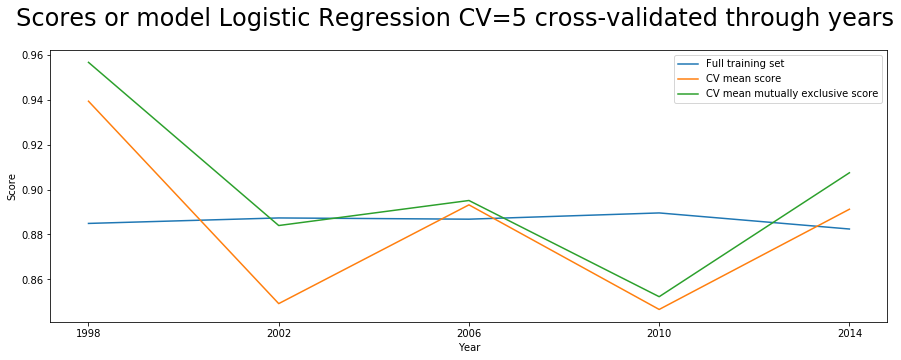

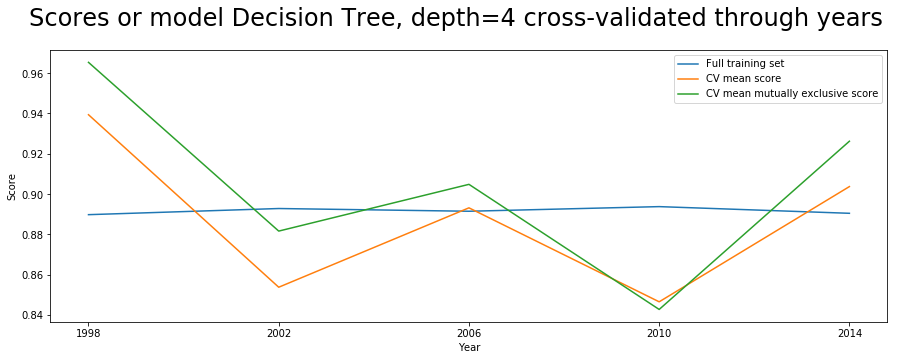

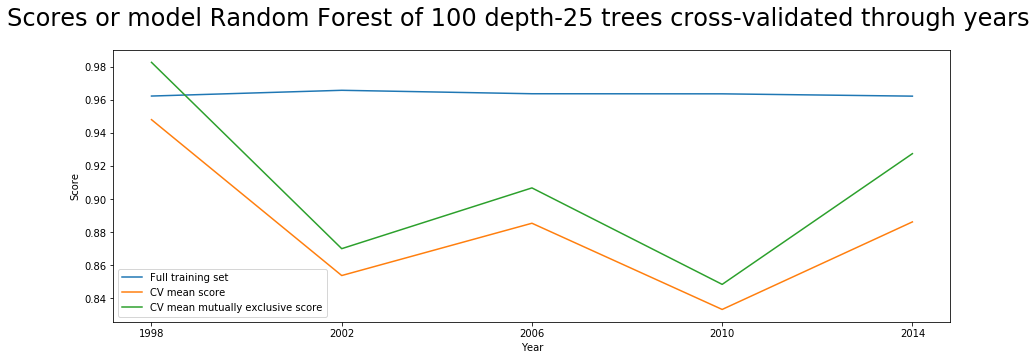

In [397]:
modelListTrain(modelList, train_data, years)

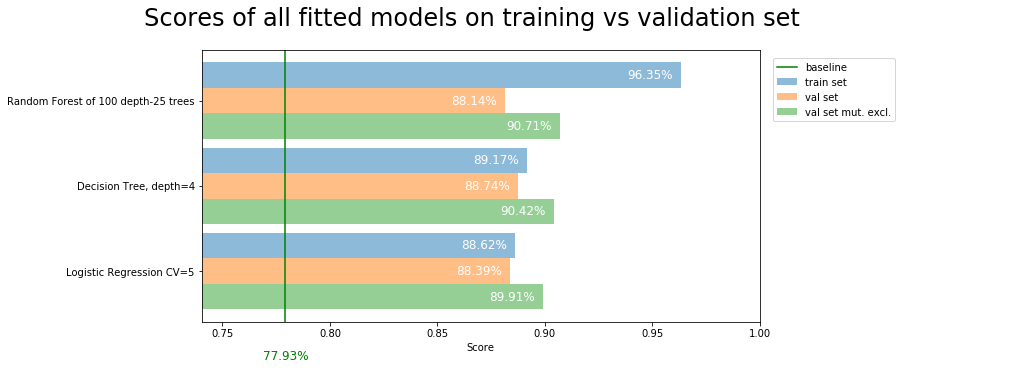

In [398]:
baseline_accuracy=0.7793 
plotModelsScores(modelList, baseline_accuracy)

,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.906796,D,1918,-1.122779,0,-2.287213,-0.967341,-1.012769,D,0.263001,-0.441832,0.30699,R,-0.501864
435,1.102784,R,1918,-1.104548,7,-2.287213,-0.967341,-1.012769,D,0.351444,-0.441832,0.30699,R,0.027491
436,-0.906796,R,1918,-1.122779,0,-2.287213,-0.967341,-1.012769,D,0.357878,-0.441832,0.30699,R,0.102977
437,1.102784,D,1918,-1.120754,1,-2.287213,-0.967341,-1.012769,D,0.362280,-0.441832,0.30699,R,0.372199
438,-0.906796,R,1918,-1.122779,0,-2.287213,-0.967341,-1.012769,D,0.362280,-0.441832,0.30699,R,0.372199


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
8304,1.102784,D,2016,-1.118728,2,-0.289474,1.033762,0.987392,R,-2.36066,-1.239664,1.249622,R,-0.251290
8305,-0.906796,R,2016,-1.122779,0,-0.289474,1.033762,0.987392,R,-2.36066,-1.239664,1.249622,R,-1.068135
8306,-0.906796,D,2016,-1.122779,0,-0.327167,1.033762,0.987392,R,-2.36066,-1.239664,1.249622,R,-1.026347
8307,1.102784,R,2016,-1.120754,1,-0.327167,1.033762,0.987392,R,-2.36066,-1.239664,1.249622,R,0.205916
8308,1.102784,R,2016,-1.118728,2,-1.231804,1.033762,0.987392,R,-2.36066,-1.239664,1.249622,R,0.001869


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.906722,D,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.360477,-0.383016,0.253815,R,-0.493993
435,1.102874,R,1918,-1.101122,7,-2.29221,-1.191375,-1.249508,D,0.432625,-0.383016,0.253815,R,0.027584
436,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.437874,-0.383016,0.253815,R,0.101961
437,1.102874,D,1918,-1.117322,1,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228
438,-0.906722,R,1918,-1.119347,0,-2.29221,-1.191375,-1.249508,D,0.441465,-0.383016,0.253815,R,0.367228


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
7504,1.102874,R,2014,-1.117322,1,0.845104,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.370966
7505,-0.906722,D,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,0.189539
7506,-0.906722,R,2014,-1.119347,0,0.728907,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.018507
7507,1.102874,R,2014,-1.115297,2,1.387355,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-0.876388
7508,-0.906722,D,2014,-1.119347,0,-0.316864,-1.191375,-1.249508,D,-0.38752,-0.766157,0.779443,R,-1.066678


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.912849,D,1918,-1.125845,0,-2.450712,-0.965158,-1.255903,D,0.358329,-0.420511,0.288252,R,-0.535272
435,1.095471,R,1918,-1.107609,7,-2.450712,-0.965158,-1.255903,D,0.430355,-0.420511,0.288252,R,0.036289
436,-0.912849,R,1918,-1.125845,0,-2.450712,-0.965158,-1.255903,D,0.435596,-0.420511,0.288252,R,0.117794
437,1.095471,D,1918,-1.123819,1,-2.450712,-0.965158,-1.255903,D,0.439180,-0.420511,0.288252,R,0.408481
438,-0.912849,R,1918,-1.125845,0,-2.450712,-0.965158,-1.255903,D,0.439180,-0.420511,0.288252,R,0.408481


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
6673,-0.912849,D,2012,-1.125845,0,1.985634,1.036099,-1.255903,D,-0.388407,-1.053396,1.064735,R,-0.379692
6674,1.095471,R,2012,-1.125845,0,0.822709,1.036099,-1.255903,D,-0.388407,-1.053396,1.064735,R,1.249575
6675,-0.912849,D,2012,-1.125845,0,0.822709,1.036099,-1.255903,D,-0.388407,-1.053396,1.064735,R,1.292079
6676,-0.912849,D,2012,-1.125845,0,0.822709,1.036099,-1.255903,D,-0.388407,-1.053396,1.064735,R,-0.212896
6677,1.095471,R,2012,-1.125845,0,0.822709,1.036099,-1.255903,D,-0.388407,-1.053396,1.064735,R,1.076827


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910866,D,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.378995,-0.255258,0.123294,R,-0.482193
435,1.097857,R,1918,-1.098254,7,-2.322152,-1.144187,-1.048784,D,0.452203,-0.255258,0.123294,R,0.026960
436,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.457529,-0.255258,0.123294,R,0.099566
437,1.097857,D,1918,-1.114440,1,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513
438,-0.910866,R,1918,-1.116463,0,-2.322152,-1.144187,-1.048784,D,0.461173,-0.255258,0.123294,R,0.358513


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
6141,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.589373
6142,1.097857,D,2010,-1.102301,7,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.547907
6143,-0.910866,R,2010,-1.116463,0,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.406174
6144,1.097857,D,2010,-1.108371,4,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,-0.093704
6145,1.097857,D,2010,-1.108371,2,1.424788,-1.144187,0.953485,D,-0.379991,1.041185,-1.008675,D,0.871234


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.907958,D,1918,-1.116067,0,-2.268924,-1.007661,-1.053107,D,0.381336,-0.295258,0.166562,R,-0.471234
435,1.101372,R,1918,-1.097860,7,-2.268924,-1.007661,-1.053107,D,0.454679,-0.295258,0.166562,R,0.029462
436,-0.907958,R,1918,-1.116067,0,-2.268924,-1.007661,-1.053107,D,0.460015,-0.295258,0.166562,R,0.100862
437,1.101372,D,1918,-1.114044,1,-2.268924,-1.007661,-1.053107,D,0.463666,-0.295258,0.166562,R,0.355509
438,-0.907958,R,1918,-1.116067,0,-2.268924,-1.007661,-1.053107,D,0.463666,-0.295258,0.166562,R,0.355509


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
5640,-0.907958,D,2008,-1.116067,0,0.182133,0.992397,0.949571,D,-0.379054,0.261749,-0.239597,D,-0.341765
5641,-0.907958,R,2008,-1.116067,0,0.182133,0.992397,0.949571,D,-0.379054,0.261749,-0.239597,D,0.355509
5642,-0.907958,R,2008,-1.116067,0,0.182133,0.992397,0.949571,D,-0.379054,0.261749,-0.239597,D,0.931164
5643,1.101372,D,2008,-1.114044,1,0.182133,0.992397,0.949571,D,-0.379054,0.261749,-0.239597,D,0.005228
5644,1.101372,D,2008,-1.114044,1,0.182133,0.992397,0.949571,D,-0.379054,0.261749,-0.239597,D,0.355509


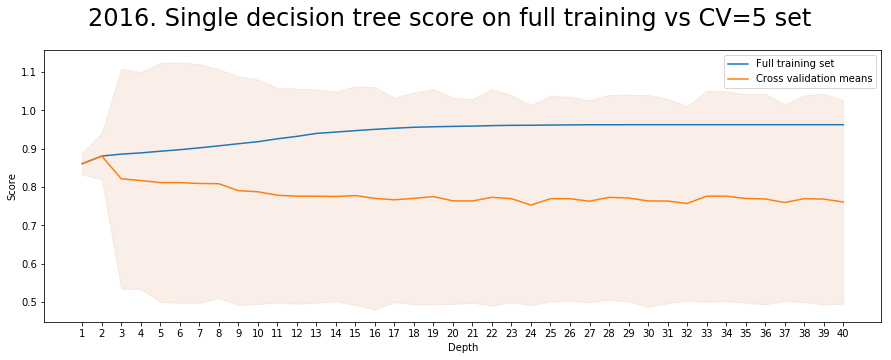

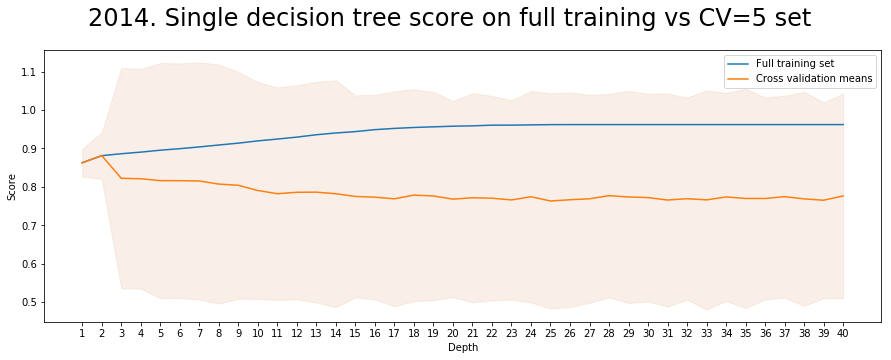

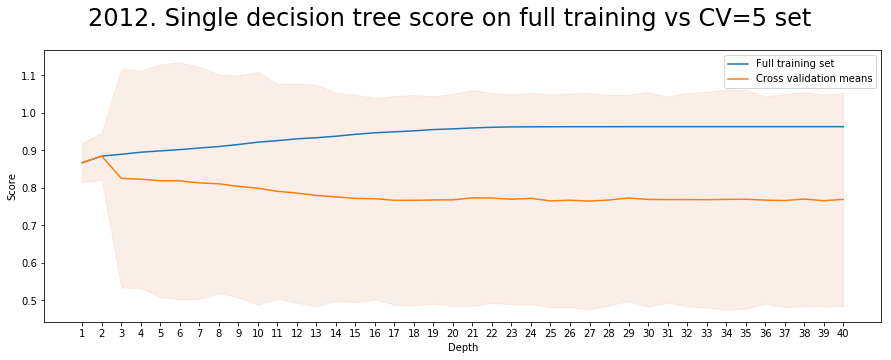

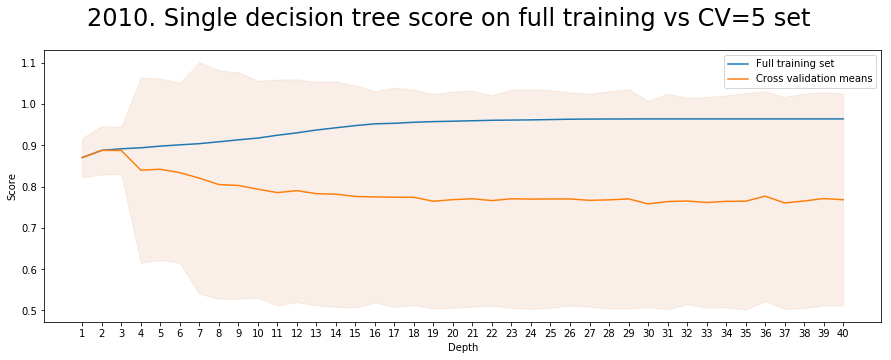

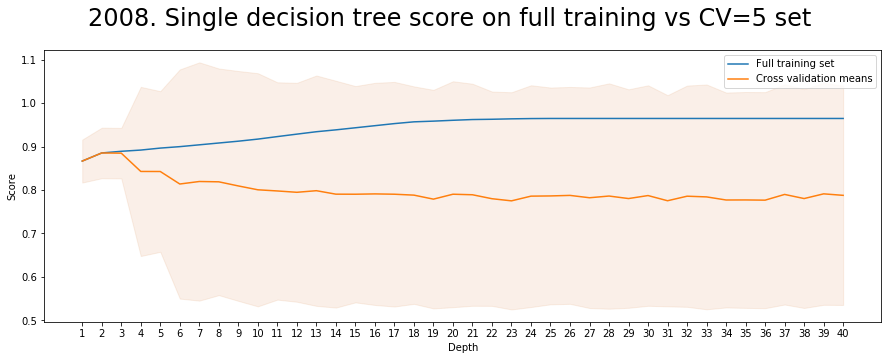

In [399]:
#find best depth for decision tree
#years=Midterm_recent_years
years=All_recent_years[:5]
for year in years:
    #split dataset
    x_train, y_train, x_val, y_val, house_df_districts = splitDf(train_data, year)

    #preprocess
    x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
    x_val_preprocess=preprocess(x_train, y_train, house_df_districts, x_val)

    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_preprocess=x_train_preprocess[list(x_val_preprocess)]

    #fit model
    depths=list(range(1,41)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_preprocess, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_preprocess, y_train)
        scores_train.append(dt.score(x_train_preprocess, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [400]:
#one shot prediction
model=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)

#split dataset using 2018 data as test set
year=2018
x_train, y_train, x_test, y_test, house_df_districts = splitDf(house_df[(house_df['year']>=yearStart)], year)

#preprocess
x_train_preprocess=preprocess(x_train, y_train, house_df_districts, x_train)
x_test_preprocess=preprocess(x_train, y_train, house_df_districts, x_test)

#fit model
fitted_model=model.fit(x_train_preprocess, y_train)

#generate predictions and calculate accuracy
Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_preprocess, x_test_preprocess, y_train, y_test, house_df_districts)

#print accuracy scores
print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\n'.format(Accu_train, Accu_val, Accu_val_2))

#print how many republican, how many democrat districts
DEM=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==0)]
REP=pred_df[(pred_df['won_pred']==1)&(pred_df['party']==1)]
print('N. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

#print uncertainties
uncertainties=pred_df[(pred_df['rel_won_proba']<0.8) & (pred_df['abs_won_proba']>0.5)]
n_uncertainties=len(uncertainties)
print('Uncertainties: {}\n'.format(n_uncertainties))

#Consolidate district results by party, instead that by candidate

,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
434,-0.910775,D,1918,-1.119094,0,-2.345261,-1.066622,-1.112214,D,0.413376,-0.318883,0.185355,R,-0.475878
435,1.097966,R,1918,-1.100889,7,-2.345261,-1.066622,-1.112214,D,0.488603,-0.318883,0.185355,R,0.031516
436,-0.910775,R,1918,-1.119094,0,-2.345261,-1.066622,-1.112214,D,0.494076,-0.318883,0.185355,R,0.103872
437,1.097966,D,1918,-1.117071,1,-2.345261,-1.066622,-1.112214,D,0.497820,-0.318883,0.185355,R,0.361925
438,-0.910775,R,1918,-1.119094,0,-2.345261,-1.066622,-1.112214,D,0.497820,-0.318883,0.185355,R,0.361925


,is_incumbent,party,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
9130,1.097966,D,2018,-1.113025,3,-0.909696,-1.066622,0.899108,R,-1.818229,-0.921555,0.931098,R,3.608168
9131,-0.910775,D,2018,-1.119094,0,-0.909696,-1.066622,0.899108,R,-1.818229,-0.921555,0.931098,R,-0.922555
9132,1.097966,D,2018,-1.115048,2,-0.909696,-1.066622,0.899108,R,-1.818229,-0.921555,0.931098,R,1.029212
9133,1.097966,D,2018,-1.113025,3,-0.909696,-1.066622,0.899108,R,-1.818229,-0.921555,0.931098,R,-0.484957
9134,1.097966,R,2018,-1.115048,2,-0.909696,-1.066622,0.899108,R,-1.818229,-0.921555,0.931098,R,-0.134255


Training accuracy: 88.73%
Validation accuracy: 85.95%
Mutually exclusive validation accuracy: 88.57%

N. Democrat districts: 182
N. Republican districts: 253
Uncertainties: 25



In [401]:
#Consolidate district results by party, instead that by candidate
winner_pred=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
actual_winners=test_data[test_data['won']==1].set_index(['state', 'district']).sort_index()
#winner_pred['won_pred'].astype(int)==actual_winners['won'].astype(int)
final_results=pd.DataFrame(columns = ['won', 'won_pred'] )
final_results['won_pred']=winner_pred['party'].astype(int).replace([0, 1], ['D', 'R'])
final_results['won']=actual_winners['party']
final_results['correct_pred']=(final_results['won_pred']==final_results['won'])
print('Correct predictions: {} on a total of {} districts ({:.2%})\n'.format(sum(final_results['correct_pred']),
                                                                       len(final_results['correct_pred']),
                                                                       sum(final_results['correct_pred'])/len(final_results['correct_pred'])))

#print how many republican, how many democrat districts
DEM=final_results[final_results['won_pred']=='D']
REP=final_results[final_results['won_pred']=='R']
print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
DEM=final_results[final_results['won']=='D']
REP=final_results[final_results['won']=='R']
print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))
final_results['abs_won_proba']=winner_pred['abs_won_proba']
final_results['rel_won_proba']=winner_pred['rel_won_proba']

print('\nFirst 5 correct predictions:')
display(final_results[final_results['correct_pred']==True].head())

print('List of wrong predictions:')
display(final_results[final_results['correct_pred']==False])
final_results.to_csv('data/final_results_map.csv', index=True)

Correct predictions: 387 on a total of 435 districts (88.97%)

Predictions:
N. Democrat districts: 182
N. Republican districts: 253

Actual results:
N. Democrat districts: 230
N. Republican districts: 205

First 5 correct predictions:


won won_pred  correct_pred  abs_won_proba  rel_won_proba
state   district                                                           
Alabama District 1   R        R          True       0.989365       0.940326
        District 2   R        R          True       0.992647       0.940511
        District 3   R        R          True       0.991210       0.940430
        District 4   R        R          True       0.992191       0.940486
        District 5   R        R          True       0.954217       0.881146

List of wrong predictions:


won won_pred  correct_pred  abs_won_proba  \
state          district                                                
Arizona        District 2    D        R         False       0.598702   
               District 9    D        R         False       0.099177   
California     District 25   D        R         False       0.923351   
               District 48   D        R         False       0.991507   
               District 49   D        R         False       0.621586   
Colorado       District 6    D        R         False       0.992514   
Florida        District 26   D        R         False       0.856476   
               District 27   D        R         False       0.114697   
Georgia        District 6    D        R         False       0.987137   
Illinois       District 14   D        R         False       0.886330   
               District 4    D        R         False       0.099177   
               District 6    D        R         False       0.798733   
Iowa           District 1    D        R         False       0.932646   
               District 3    D        R         False       0.935942   
Kansas         District 3    D        R         False       0.952146   
Maryland       District 6    D        R         False       0.598952   
Michigan       District 11   D        R         False       0.102691   
               District 8    D        R         False       0.880797   
Minnesota      District 2    D        R         False       0.987377   
               District 3    D        R         False       0.993504   
Nevada         District 3    D        R         False       0.621134   
               District 4    D        R         False       0.117743   
New Hampshire  District 1    D        R         False       0.099177   
New Jersey     District 11   D        R         False       0.099177   
               District 2    D        R         False       0.125131   
               District 3    D        R         False       0.878918   
               District 7    D        R         False       0.994294   
New Mexico     District 1    D        R         False       0.614220   
               District 2    D        R         False       0.614220   
New York       District 11   D        R         False       0.853989   
               District 19   D        R         False       0.986865   
               District 22   D        R         False       0.921270   
               District 25   D        R         False       0.218671   
Oklahoma       District 5    D        R         False       0.865457   
Pennsylvania   District 17   D        R         False       0.814050   
               District 4    D        R         False       0.195345   
               District 5    D        R         False       0.614220   
               District 6    D        R         False       0.099903   
               District 7    D        R         False       0.110738   
South Carolina District 1    D        R         False       0.099177   
Texas          District 16   D        R         False       0.099177   
               District 32   D        R         False       0.995727   
               District 7    D        R         False       0.995910   
Utah           District 4    D        R         False       0.861894   
Virginia       District 10   D        R         False       0.988457   
               District 2    D        R         False       0.918051   
               District 7    D        R         False       0.875663   
Washington     District 8    D        R         False       0.094358   

                            rel_won_proba  
state          district                    
Arizona        District 2        0.903100  
               District 9        0.601681  
California     District 25       0.880616  
               District 48       0.943026  
               District 49       0.911669  
Colorado       District 6        0.941406  
Florida        District 26       0.929480  
               District 27    

(array([393.,  35.,   3.,   0.,  11.,  22.,   4.,  31., 130., 211.]),
 array([0.05234378, 0.14685692, 0.24137005, 0.33588319, 0.43039632,
        0.52490945, 0.61942259, 0.71393572, 0.80844886, 0.90296199,
        0.99747513]),
 <a list of 10 Patch objects>)

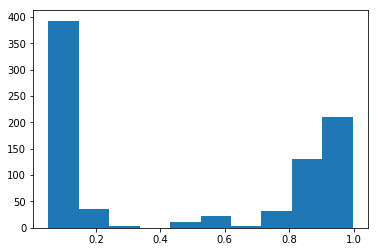

In [402]:
plt.hist(pred_df['abs_won_proba'])

(array([321.,  36.,   0.,  40.,   9.,  40.,   8.,   3., 134., 249.]),
 array([0.05310252, 0.14779227, 0.24248202, 0.33717177, 0.43186151,
        0.52655126, 0.62124101, 0.71593076, 0.8106205 , 0.90531025,
        1.        ]),
 <a list of 10 Patch objects>)

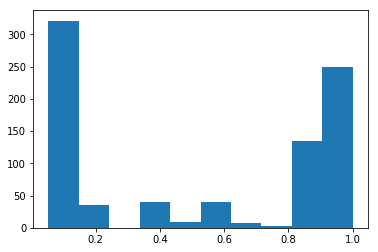

In [403]:
plt.hist(pred_df['rel_won_proba'])

In [404]:
from sklearn.feature_selection import chi2
scores, pvalues = chi2(x_train_preprocess, y_train)

featureImportance=pd.DataFrame([list(x_train_preprocess), list(pvalues)]).T
featureImportance.columns=['coeff', 'p-value']
featureImportance=featureImportance.set_index('coeff')
display(featureImportance)

ValueError: Input X must be non-negative.